# Analyzing CyclePronto Data

This is a work-in-progress, analyzing the open data from [Pronto Cycle Share's Data Challenge](http://www.prontocycleshare.com/datachallenge).

We'll start by downloading the data, which you can do with these commands:

In [1]:
#!curl -O https://s3.amazonaws.com/pronto-data/open_data_year_one.zip
#!unzip open_data_year_one.zip

Some standard Python imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

And now we load the trip data with Pandas:

In [3]:
trips = pd.read_csv('2015_trip_data.csv',
                    parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True)
trips.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971


## Exploring Trips over Time

Let's look at some of the usage over time:

In [4]:
# convert date to datetime64 – more methods are available
trips['date'] = trips.starttime.map(pd.Timestamp.date).astype('datetime64')

In [5]:
# Count trips by date
by_date = trips.pivot_table('trip_id', aggfunc='count',
                            index='date',
                            columns='usertype', )

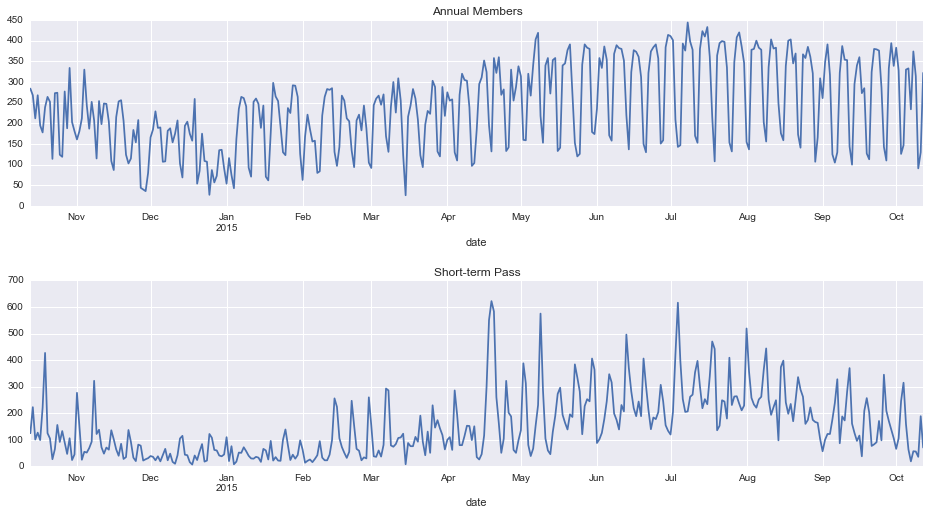

In [6]:
fig, ax = plt.subplots(2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.4)
by_date.iloc[:, 0].plot(ax=ax[0], title='Annual Members');
by_date.iloc[:, 1].plot(ax=ax[1], title='Short-term Pass');

A couple observations:

- The big spike in short-term pass rides in April is likely due to the [American Planning Association national conference](http://www.planetizen.com/node/75958/seattle-sets-bikeshare-record-apa-town), held in downtown Seattle that week.
- Interestingly, the 4th of July weekend nearly matches this record day-pass usage.
- Day pass users seem to show an ebb and flow with summer months; the usage of annual users has not waned as significantly with the coming of fall.
- Both annual members and day-pass users seem to show a distinct weekly trend.

Let's narrow-in on this weekly trend, by averaging all rides by day of week.
We'll split the data by year and by day of week:

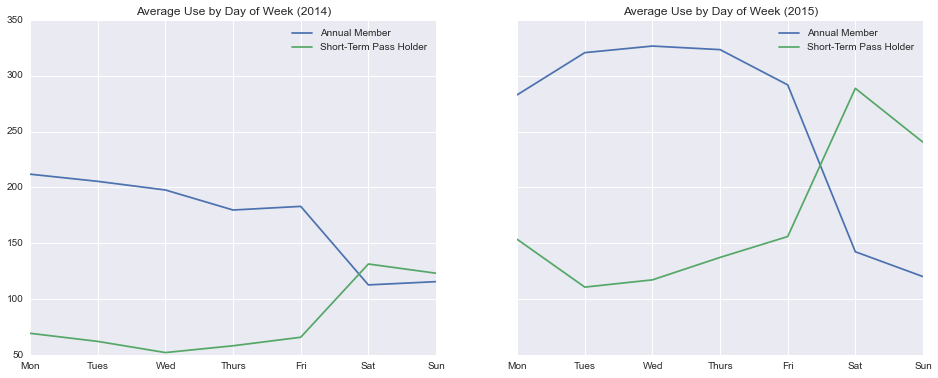

In [7]:
by_weekday = by_date.groupby([by_date.index.year, by_date.index.dayofweek]).mean()
by_weekday.columns.name = None

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
by_weekday.loc[2014].plot(title='Average Use by Day of Week (2014)', ax=ax[0]);
by_weekday.loc[2015].plot(title='Average Use by Day of Week (2015)', ax=ax[1]);
for axi in ax:
    axi.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

We see a complementary pattern overall: annual users tend to use their bikes during Monday to Friday (i.e. as part of a commute) while day pass users tend to use their bikes on the weekend.
This pattern didn't fully develop until the start of 2015, however, especially for annual members: it seems that for the first couple months, users were not quite sure how to best utilize the system!

## Trip Durations

Next let's take a look at the durations of trips.
Pronto rides are meant to be up to 30 minutes; longer than this incurs a usage fee.
Let's look at how

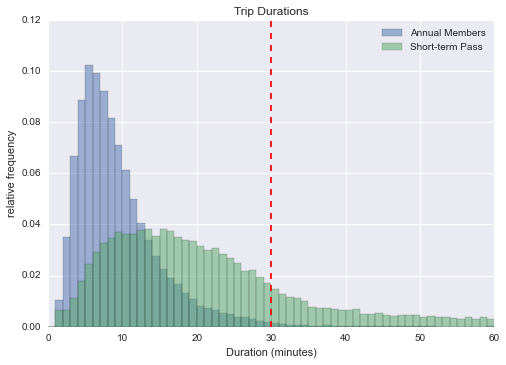

In [8]:
trips['minutes'] = trips.tripduration / 60
trips.groupby('usertype')['minutes'].hist(bins=np.arange(61), alpha=0.5, normed=True);
plt.xlabel('Duration (minutes)')
plt.ylabel('relative frequency')
plt.title('Trip Durations')
plt.legend(['Annual Members', 'Short-term Pass'])

plt.axvline(30, linestyle='--', color='red');

It seems that annual users are much more savvy to the system rules: only a small tail of the trip distribution lies beyond 30 minutes.
Day Pass Users, on the other hand, don't seem to be as aware that rides beyond 30 minutes incur additional fees. In fact, this long tail of Day-pass use stretches out to 4+ hours – given that this costs about [$10/hour after the first hour](https://www.prontocycleshare.com/pricing) for a single use, my guess is this is indicative of confusion on the part of day-pass users.

## Trip Distances

It's also interesting to look at the distance of the trips.
Distances between stations are not included in the data release, so we need to find them.
Let's start by loading the station data – some of the trips begin and end at the pronto shop, so let's add this to our dataset:

In [9]:
stations = pd.read_csv('2015_station_data.csv')
pronto_shop = dict(id=54, name="Pronto shop",
                   terminal="Pronto shop",
                   lat=47.6173156, long=-122.3414776,
                   dockcount=100, online='10/13/2014')
stations = stations.append(pronto_shop, ignore_index=True)
stations.head()

,id,name,terminal,lat,long,dockcount,online
0,1,3rd Ave & Broad St,BT-01,47.618418,-122.350964,18,10/13/2014
1,2,2nd Ave & Vine St,BT-03,47.615829,-122.348564,16,10/13/2014
2,3,6th Ave & Blanchard St,BT-04,47.616094,-122.341102,16,10/13/2014
3,4,2nd Ave & Blanchard St,BT-05,47.613110,-122.344208,14,10/13/2014
4,5,2nd Ave & Pine St,CBD-13,47.610185,-122.339641,18,10/13/2014


Now we need to find bicycling distances between pairs of lat/lon coordinates.
Fortunately, Google Maps has an API that we can use for free:

https://developers.google.com/maps/documentation/distance-matrix/intro

Reading the fine print, free use is limited to 2500 distances per day, 100 per request, and 100 per 10 seconds.
With 55 stations we have $55 \times 54 / 2 = 1485$ unique nontrivial distances, so we can just query all of them within a few minutes on a single day, but we'll need to do it carefully.
We'll query one (partial) row at a time, waiting 10+ seconds between queries (Note: we might also use https://github.com/googlemaps/google-maps-services-python instead – I don't have experience with this package).

In [10]:
from time import sleep

def query_distances(stations=stations):
    latlon_list = ['{0},{1}'.format(lat, long)
                   for (lat, long) in zip(stations.lat, stations.long)]

    def create_url(i):
        URL = ('https://maps.googleapis.com/maps/api/distancematrix/json?'
               'origins={origins}&destinations={destinations}&mode=bicycling')
        return URL.format(origins=latlon_list[i],
                          destinations='|'.join(latlon_list[i + 1:]))

    for i in range(len(latlon_list) - 1):
        url = create_url(i)
        filename = "distances_{0}.json".format(stations.terminal.iloc[i])
        print(i, filename)
        !curl "{url}" -o {filename}
        sleep(11)


def build_distance_matrix(stations=stations):
    dist = np.zeros((len(stations), len(stations)), dtype=float)
    for i, term in enumerate(stations.terminal[:-1]):
        filename = 'queried_distances/distances_{0}.json'.format(term)
        row = json.load(open(filename))
        dist[i, i + 1:] = [el['distance']['value'] for el in row['rows'][0]['elements']]
    dist += dist.T
    distances = pd.DataFrame(dist, index=stations.terminal,
                             columns=stations.terminal)
    distances.to_csv('station_distances.csv')
    return distances

# only call this the first time
import os
if not os.path.exists('station_distances.csv'):
    # Note: you can call this function at most ~twice per day!
    query_distances()

    # Move all the queried files into a directory
    # so we don't accidentally overwrite them
    if not os.path.exists('queried_distances'):
        os.makedirs('queried_distances')
        
    !mv distances_*.json queried_distances

    # Build distance matrix and save to CSV
    distances = build_distance_matrix()

Now let's load this distance matrix to see what we have:

In [11]:
distances = pd.read_csv('station_distances.csv', index_col='terminal')
distances.iloc[:5, :5]

,BT-01,BT-03,BT-04,BT-05,CBD-13
terminal,,,,,
BT-01,0,422,1067,867,1342
BT-03,422,0,838,445,920
BT-04,1067,838,0,1094,1121
BT-05,867,445,1094,0,475
CBD-13,1342,920,1121,475,0


Now we can join these distances to our trips data, converting from meters to miles

In [12]:
stacked.rename?

Object `stacked.rename` not found.


In [13]:
stacked = distances.stack() / 1609.34  # convert meters to miles
stacked.name = 'distance'
trips = trips.join(stacked, on=['from_station_id', 'to_station_id'])

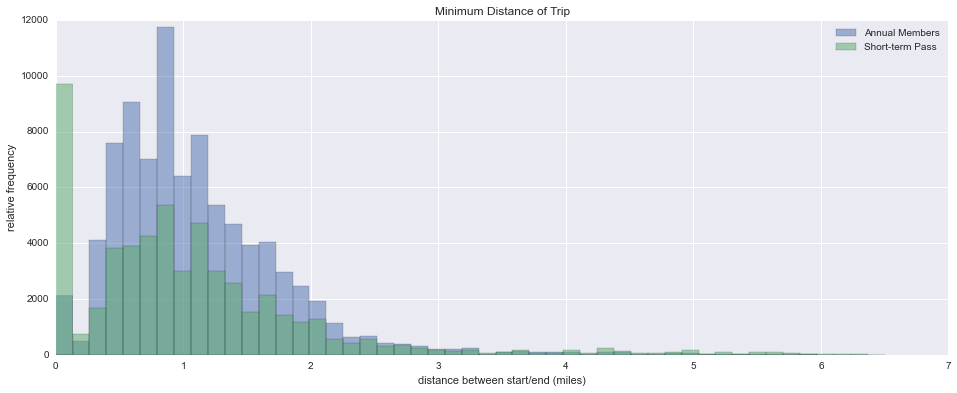

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))
trips.groupby('usertype')['distance'].hist(bins=np.linspace(0, 6.5, 50),
                                           alpha=0.5, ax=ax);
plt.xlabel('distance between start/end (miles)')
plt.ylabel('relative frequency')
plt.title('Minimum Distance of Trip')
plt.legend(['Annual Members', 'Short-term Pass']);

This shows the distance between spaces, and thus is a **lower bound** on the length of each trip.
Many trips (especially for day pass users) begin and end very nearby. Beyond this, it seems like most trips are around 1 mile, though some extreme users are pushing their trips out to 4, 5, 6 or more miles.

## Ride Speed

Given these distances, we can compute a lower bound on the riding speed:

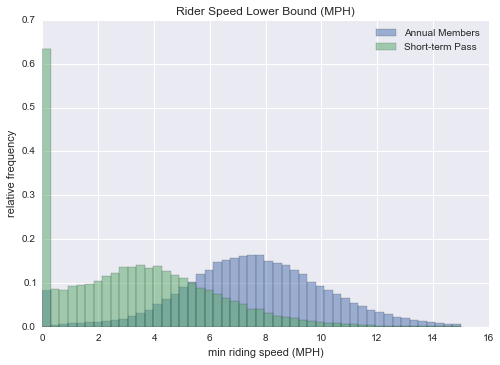

In [15]:
trips['speed'] = trips.distance * 60 / trips.minutes
trips.groupby('usertype')['speed'].hist(bins=np.linspace(0, 15, 50), alpha=0.5, normed=True);
plt.xlabel('min riding speed (MPH)')
plt.ylabel('relative frequency')
plt.title('Rider Speed Lower Bound (MPH)')
plt.legend(['Annual Members', 'Short-term Pass']);

The pattern shown for short-term and annual users is interesting: annual members are either riding faster than day users, or perhaps they are riding directly from point A to point B rather than meandering around a single neighborhood.

The distribution is a classic bell curve, and we can compute the mean and standard deviation:

In [16]:
speed = trips.query('usertype == "Annual Member" & speed > 0').speed
print("avg speed = {0:.1f} +/- {1:.1f}".format(speed.mean(), speed.std()))

avg speed = 7.8 +/- 2.7


It's also interesting to take a look at the relationship between distance and speed:

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


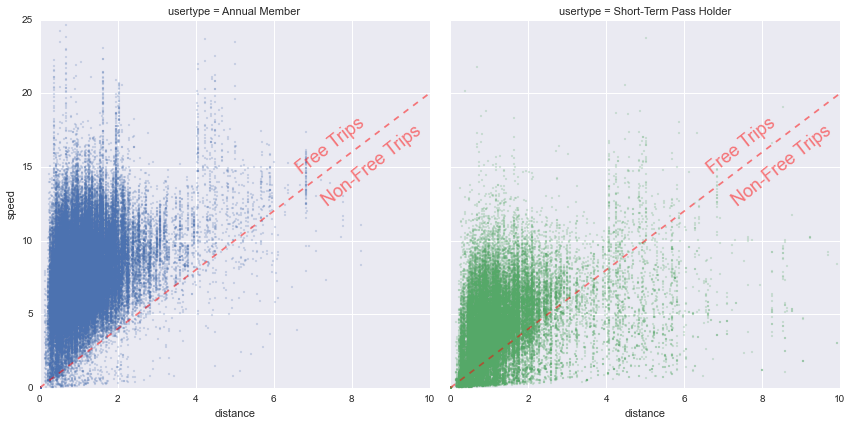

In [17]:
g = sns.FacetGrid(trips, col="usertype", hue='usertype', size=6)
g.map(plt.scatter, "distance", "speed", s=4, alpha=0.2)

x = np.linspace(0, 10)
for ax in g.axes.flat:
    ax.plot(x, 2 * x, '--r', alpha=0.5)
    ax.text(6.5, 16.5, "Free Trips\n\nNon-Free Trips",
            size=18, rotation=38, alpha=0.5, color='red')
    ax.axis([0, 10, 0, 25])

For reference, we have plotted the line separating free trips (above the red line) from non-free trips (below the red line).
Again we see that the annual members are much more savvy about not going over the half hour limit than are day pass users.

## Trend with Elevation

One of the major concerns with Pronto is that Seattle is a hilly city – before the launch, armchair analysts predicted that there would be a steady flow of bikes from uphill to downhill, and that this would add up with other challenges to spell the demise of the system ("Sure, bikeshare works other places, but it can't work here: Seattle is *special*! We're just *so special*!)

Elevation data is not included in the data release, but again we can turn to the Google Maps API to get what we need:

https://developers.google.com/maps/documentation/elevation/intro

Here the limit is 2500 requests per day; 512 elevations per request, and 10 requests per second.
Since we only need 50 elevations, we can do it in a single go:

In [18]:
def get_station_elevations(stations):
    """Get station elevations via Google Maps API"""
    URL = "https://maps.googleapis.com/maps/api/elevation/json?locations="
    locs = '|'.join(['{0},{1}'.format(lat, long)
                     for (lat, long) in zip(stations.lat, stations.long)])
    URL += locs
    !curl "{URL}" -o elevations.json


def process_station_elevations():
    """Convert Elevations JSON output to CSV"""
    import json
    D = json.load(open('elevations.json'))
    def unnest(D):
        loc = D.pop('location')
        loc.update(D)
        return loc
    elevs = pd.DataFrame([unnest(item) for item in D['results']])
    elevs.to_csv('station_elevations.csv')
    return elevs

# only run this the first time:
import os
if not os.path.exists('station_elevations.json'):
    get_station_elevations(stations)
    process_station_elevations()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11062    0 11062    0     0  17816      0 --:--:-- --:--:-- --:--:-- 44604


Now let's read-in the elevation data:

In [19]:
elevs = pd.read_csv('station_elevations.csv', index_col=0)
elevs.head()

,elevation,lat,lng,resolution
0,37.351780,47.618418,-122.350964,76.351616
1,33.815830,47.615829,-122.348564,76.351616
2,34.274055,47.616094,-122.341102,76.351616
3,44.283257,47.613110,-122.344208,76.351616
4,42.460381,47.610185,-122.339641,76.351616


Just to make ourselves feel better, we'll double check that the latitudes and longitudes match:

In [20]:
# double check that locations match
print(np.allclose(stations.long, elevs.lng))
print(np.allclose(stations.lat, elevs.lat))

True
True


Now we can add the elevations to the stations data, and then join this data with our trips:

In [21]:
stations['elevation'] = elevs['elevation']
elevs.index = stations['terminal']

trips['elevation_start'] = trips.join(elevs, on='from_station_id')['elevation']
trips['elevation_end'] = trips.join(elevs, on='to_station_id')['elevation']
trips['elevation_gain'] = trips['elevation_end'] - trips['elevation_start']

Now lets look at the distribution of start/end elevation by user type:

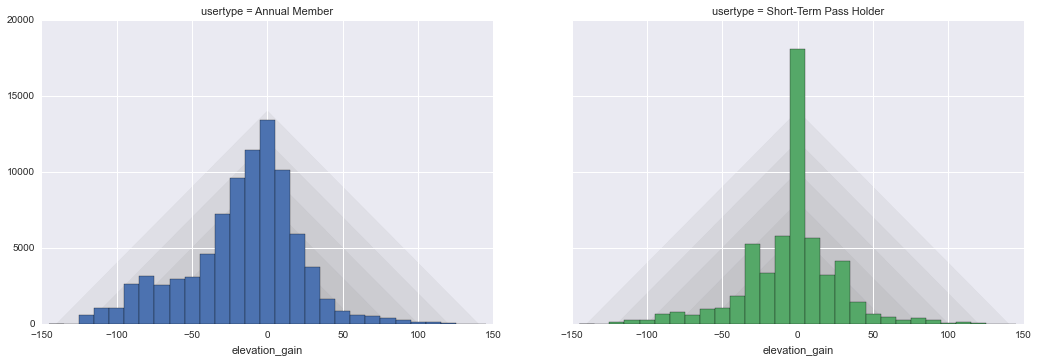

In [22]:
g = sns.FacetGrid(trips, col="usertype", hue='usertype')
g.map(plt.hist, "elevation_gain", bins=np.arange(-145, 150, 10))
g.fig.set_figheight(6)
g.fig.set_figwidth(16);

# plot some lines to guide the eye
for lim in range(60, 150, 20):
    x = np.linspace(-lim, lim, 3)
    for ax in g.axes.flat:
        ax.fill(x, 100 * (lim - abs(x)),
                color='gray', alpha=0.1, zorder=0)

We have plotted some shading in the background to help guide the eye.
Again, there is a big difference between Annual and Daily users: annual users definitely show a preference for downhill trips (left of the distribution), while daily users dont show this as strongly.
To make this more concrete:

In [23]:
print("total downhill trips:", (trips.elevation_gain < 0).sum())
print("total uphill trips:  ", (trips.elevation_gain > 0).sum())

total downhill trips: 80532
total uphill trips:   50493


We see that there are about 60% more uphill trips than downhill trips, which means given current usage levels that Pronto staff must be shuttling an average of about 100 bikes per day from low-lying stations to higher-up stations.

## Weather

The other "Seattle is special" argument against cycle share is the weather.
Let's take a look at how the weather affects rides.
The data release includes weather data:

In [24]:
weather = pd.read_csv('2015_weather_data.csv', index_col='Date', parse_dates=True)
weather.columns

Index(['Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF',
       'Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity',
       'Mean_Humidity ', 'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ', 'Mean_Wind_Speed_MPH ',
       'Max_Gust_Speed_MPH', 'Precipitation_In ', 'Events'],
      dtype='object')

Now we can group the trip data by date, and join it with the weather data:

In [25]:
by_date = trips.groupby(['date', 'usertype'])['trip_id'].count()
by_date.name = 'count'
by_date = by_date.reset_index('usertype').join(weather)
by_date['weekend'] = (by_date.index.dayofweek >= 5)

Let's take a look at how the number of rides scales with temperature and precipitation:

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


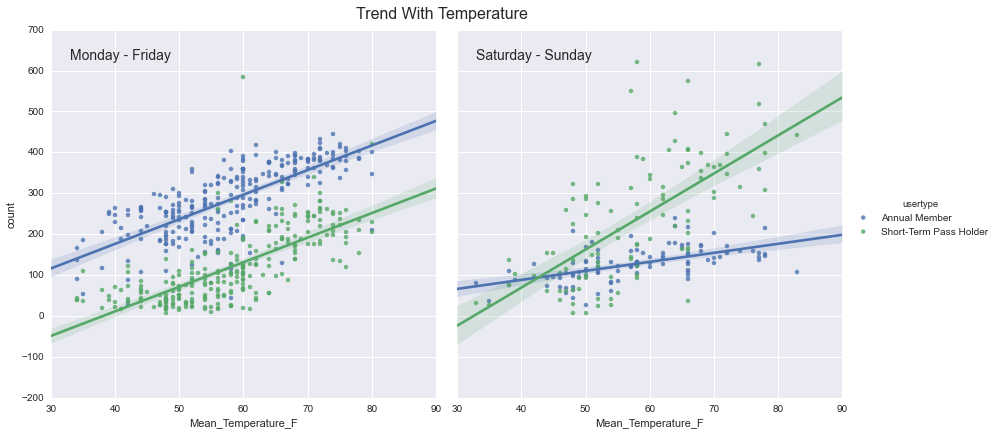

In [26]:
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Mean_Temperature_F", "count")
g.add_legend();

# do some formatting
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Trend With Temperature", ha='center', va='top', size=16);

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


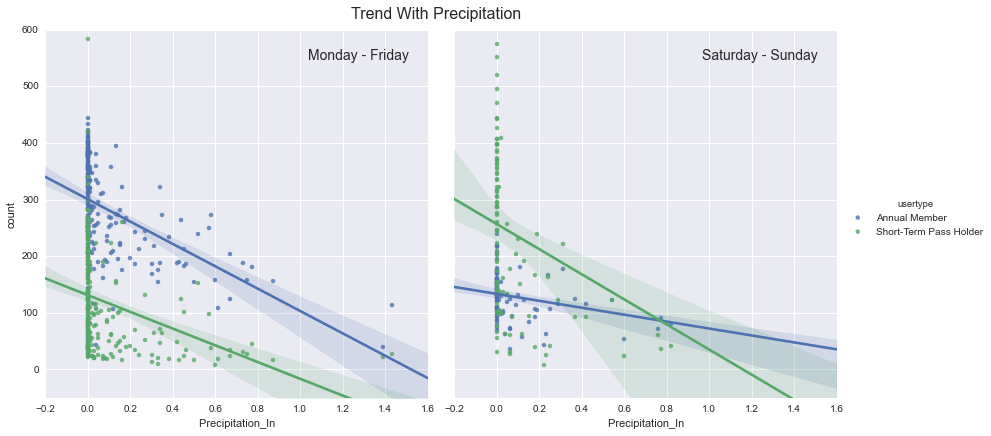

In [27]:
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Precipitation_In ", "count")
g.add_legend();

# do some formatting
g.axes[0, 0].set_ylim(-50, 600);
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.95, 0.95, 'Monday - Friday', ha='right', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.95, 0.95, 'Saturday - Sunday', ha='right', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Trend With Precipitation", ha='center', va='top', size=16);

We see a very interesting generalization across both precipitation and temperature: during the work week, both annual and daily users are about equally affected by weather, and exactly in the way you would expect
During the weekend, the effect of weather is **stronger for day-pass users**, and **weaker for annual users**.